# 1. IMPORTS AND SETUP

In [7]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB\n")

Skipping import of cpp extensions due to incompatible torch version 2.6.0+cu124 for torchao version 0.14.1             Please see https://github.com/pytorch/ao/issues/2919 for more info


Using device: cuda
GPU: NVIDIA GeForce RTX 4050 Laptop GPU
VRAM: 6.44 GB



# 2. MODEL SELECTION


In [8]:
MODEL_NAME = "distilbert-base-uncased"
MAX_LENGTH = 512  # DistilBERT supports up to 512 tokens
TRUNCATION_STRATEGY = "head_tail" 

# 3. LOAD AND PREPROCESS DATA


Loading data...
Train columns: ['text', 'label']
Test columns: ['text', 'label']
✓ Renamed 'label' column to 'sentiment'
Train: 22500, Val: 2500, Test: 25000
Label distribution - Train: {0: 11250, 1: 11250}

Truncation Analysis:
  Reviews > 384 words: 3232 (14.4%)
  These reviews will be truncated using 'head_tail' strategy
  Median review length: 174 words
  95th percentile: 596 words

✓ Saved: data_distribution.png


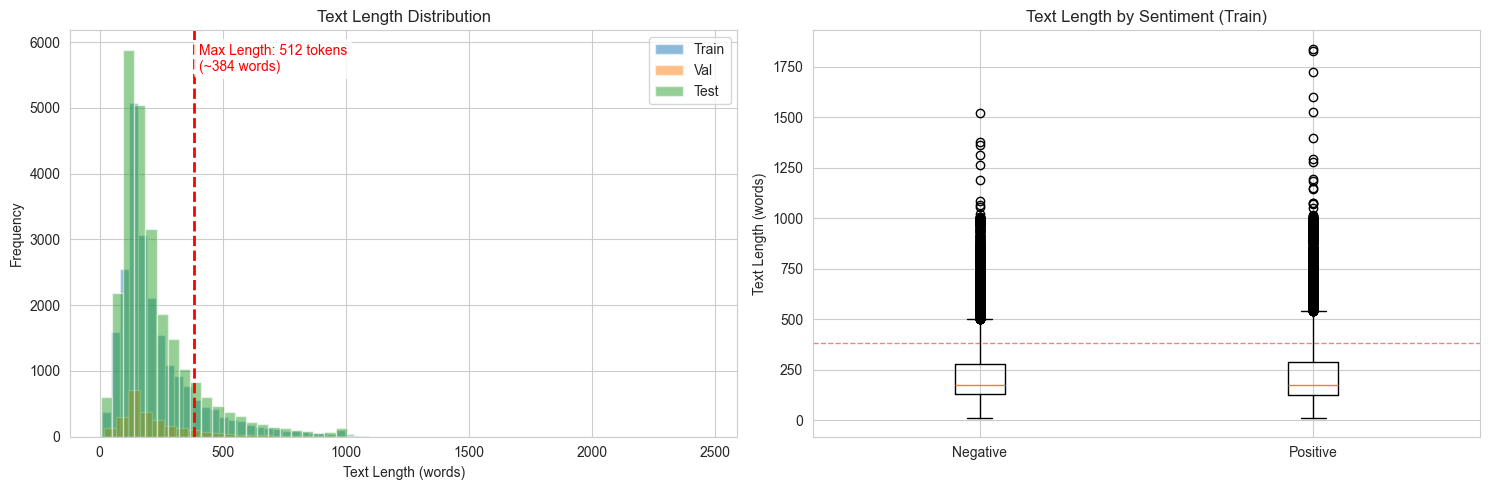

✓ Saved: text_length_analysis.png



In [9]:
print("Loading data...")
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Check column names and rename if needed
print(f"Train columns: {train_df.columns.tolist()}")
print(f"Test columns: {test_df.columns.tolist()}")

# Rename 'label' to 'sentiment' if needed for consistency
if 'label' in train_df.columns and 'sentiment' not in train_df.columns:
    train_df = train_df.rename(columns={'label': 'sentiment'})
    test_df = test_df.rename(columns={'label': 'sentiment'})
    print("✓ Renamed 'label' column to 'sentiment'")

# Verify we have required columns
if 'text' not in train_df.columns or 'sentiment' not in train_df.columns:
    raise ValueError(f"Required columns 'text' and 'sentiment' not found. Found: {train_df.columns.tolist()}")

# Create validation split (10% of training data)
train_df, val_df = train_test_split(
    train_df, test_size=0.1, random_state=42, stratify=train_df['sentiment']
)

# Calculate text lengths
train_df['text_length'] = train_df['text'].str.split().str.len()
val_df['text_length'] = val_df['text'].str.split().str.len()
test_df['text_length'] = test_df['text'].str.split().str.len()

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
print(f"Label distribution - Train: {train_df['sentiment'].value_counts().to_dict()}")

# Analyze truncation impact
max_words = int(MAX_LENGTH * 0.75)  # Rough conversion: tokens to words
long_reviews = train_df[train_df['text_length'] > max_words].shape[0]
total_reviews = len(train_df)
truncation_pct = (long_reviews / total_reviews) * 100
print(f"\nTruncation Analysis:")
print(f"  Reviews > {max_words} words: {long_reviews} ({truncation_pct:.1f}%)")
print(f"  These reviews will be truncated using '{TRUNCATION_STRATEGY}' strategy")
print(f"  Median review length: {train_df['text_length'].median():.0f} words")
print(f"  95th percentile: {train_df['text_length'].quantile(0.95):.0f} words\n")

# Visualize data distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, (name, df) in enumerate([('Train', train_df), ('Val', val_df), ('Test', test_df)]):
    counts = df['sentiment'].value_counts()
    axes[idx].bar(['Negative (0)', 'Positive (1)'], counts.values, color=['#ff6b6b', '#51cf66'])
    axes[idx].set_title(f'{name} Set Distribution')
    axes[idx].set_ylabel('Count')
    for i, v in enumerate(counts.values):
        axes[idx].text(i, v, str(v), ha='center', va='bottom')
plt.tight_layout()
plt.savefig('data_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Saved: data_distribution.png")
plt.close()

# Text length analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution plot
for name, df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    axes[0].hist(df['text_length'], bins=50, alpha=0.5, label=name)
axes[0].set_xlabel('Text Length (words)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Text Length Distribution')
axes[0].legend()
axes[0].axvline(x=max_words, color='red', linestyle='--', linewidth=2)
axes[0].text(max_words + 20, axes[0].get_ylim()[1]*0.9, 
             f'Max Length: {MAX_LENGTH} tokens\n(~{max_words} words)', 
             color='red', fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Box plot by sentiment
train_df_plot = train_df.copy()
train_df_plot['sentiment_label'] = train_df_plot['sentiment'].map({0: 'Negative', 1: 'Positive'})
data_to_plot = [train_df_plot[train_df_plot['sentiment']==0]['text_length'],
                train_df_plot[train_df_plot['sentiment']==1]['text_length']]
axes[1].boxplot(data_to_plot, labels=['Negative', 'Positive'])
axes[1].set_ylabel('Text Length (words)')
axes[1].set_title('Text Length by Sentiment (Train)')
axes[1].axhline(y=max_words, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.tight_layout()
plt.savefig('text_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: text_length_analysis.png\n")

# Convert to HuggingFace datasets
train_dataset = Dataset.from_pandas(train_df[['text', 'sentiment']])
val_dataset = Dataset.from_pandas(val_df[['text', 'sentiment']])
test_dataset = Dataset.from_pandas(test_df[['text', 'sentiment']])

dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})


In [10]:
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

# Add padding token if missing
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def preprocess_function(examples):
    """Tokenize with smart truncation strategy for long texts"""
    
    if TRUNCATION_STRATEGY == "head":
        # Standard: Keep first MAX_LENGTH tokens (beginning of review)
        return tokenizer(
            examples['text'],
            truncation=True,
            max_length=MAX_LENGTH,
            padding=False
        )
    
    elif TRUNCATION_STRATEGY == "tail":
        # Keep last MAX_LENGTH tokens (end of review)
        tokenized = tokenizer(
            examples['text'],
            truncation=False,
            padding=False
        )
        # Truncate from the beginning
        for key in tokenized.keys():
            tokenized[key] = [ids[-MAX_LENGTH:] if len(ids) > MAX_LENGTH else ids 
                             for ids in tokenized[key]]
        return tokenized
    
    elif TRUNCATION_STRATEGY == "head_tail":
        # Keep first half + last half (captures intro + conclusion)
        half_length = MAX_LENGTH // 2
        tokenized = tokenizer(
            examples['text'],
            truncation=False,
            padding=False
        )
        
        for key in tokenized.keys():
            new_ids = []
            for ids in tokenized[key]:
                if len(ids) <= MAX_LENGTH:
                    new_ids.append(ids)
                else:
                    # Concatenate first half and last half
                    combined = ids[:half_length] + ids[-half_length:]
                    new_ids.append(combined)
            tokenized[key] = new_ids
        return tokenized
    
    else:
        # Default: standard truncation
        return tokenizer(
            examples['text'],
            truncation=True,
            max_length=MAX_LENGTH,
            padding=False
        )

print(f"Tokenizing datasets with '{TRUNCATION_STRATEGY}' strategy...")
tokenized_dataset = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=['text'],
    desc="Tokenizing"
)

# Rename label column
tokenized_dataset = tokenized_dataset.rename_column("sentiment", "labels")
print("✓ Tokenization complete\n")


Loading tokenizer...
Tokenizing datasets with 'head_tail' strategy...


Tokenizing:   0%|          | 0/22500 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (599 > 512). Running this sequence through the model will result in indexing errors


Tokenizing:   0%|          | 0/2500 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/25000 [00:00<?, ? examples/s]

✓ Tokenization complete



# 5. MODEL LOADING WITH QUANTIZATION


In [ ]:
print("Loading model...")

# For DistilBERT and Longformer (no quantization needed)
if "distilbert" in MODEL_NAME.lower() or "longformer" in MODEL_NAME.lower():
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2,
        id2label={0: "negative", 1: "positive"},
        label2id={"negative": 0, "positive": 1}
    )
else:
    # For larger models (TinyLlama, Phi-2) - use 4-bit quantization
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True
    )
    
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True,
        id2label={0: "negative", 1: "positive"},
        label2id={"negative": 0, "positive": 1}
    )

model.to(device)
print("✓ Model loaded\n")

Loading model...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded



# 6. PRE-TRAINING EVALUATION


In [7]:
from tqdm import tqdm

def evaluate_model(model, dataset, dataset_name="Test", batch_size=64):
    """Evaluate model and return detailed metrics - OPTIMIZED"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    
    from torch.utils.data import DataLoader
    
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        collate_fn=data_collator,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    print(f"Evaluating {len(dataset)} samples with batch_size={batch_size}...")
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Evaluating {dataset_name}"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=-1)
            preds = torch.argmax(logits, dim=-1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary'
    )
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro'
    )
    
    print(f"\n{dataset_name} Set Results:")
    print(f"  Accuracy:          {accuracy:.4f}")
    print(f"  Precision (binary): {precision:.4f}")
    print(f"  Recall (binary):    {recall:.4f}")
    print(f"  F1 (binary):       {f1:.4f}")
    print(f"  Precision (macro): {precision_macro:.4f}")
    print(f"  Recall (macro):    {recall_macro:.4f}")
    print(f"  F1 (macro):        {f1_macro:.4f}")
    
    return {
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro
    }

print("✓ Evaluation function ready")


✓ Evaluation function ready


In [8]:
print("="*70)
print("EVALUATING PRETRAINED MODEL (Before Fine-tuning)")
print("="*70)

# Option 1: Full test set (recommended but slower)
pretrain_results = evaluate_model(model, tokenized_dataset["test"], "Pre-training Test", batch_size=64)

# Option 2: Quick evaluation on subset (uncomment to use)
# test_subset = tokenized_dataset["test"].select(range(1000))
# pretrain_results = evaluate_model(model, test_subset, "Pre-training Test (1000 samples)", batch_size=64)

# Store baseline metrics
baseline_metrics = {
    'accuracy': pretrain_results['accuracy'],
    'f1_macro': pretrain_results['f1_macro'],
    'f1_binary': pretrain_results['f1']}

EVALUATING PRETRAINED MODEL (Before Fine-tuning)
Evaluating 25000 samples with batch_size=64...


Evaluating Pre-training Test: 100%|██████████| 391/391 [04:08<00:00,  1.57it/s]


Pre-training Test Set Results:
  Accuracy:          0.5000
  Precision (binary): 1.0000
  Recall (binary):    0.0001
  F1 (binary):       0.0002
  Precision (macro): 0.7500
  Recall (macro):    0.5000
  F1 (macro):        0.3334


# 7. LORA CONFIGURATION


In [9]:
print("\n" + "="*70)
print("CONFIGURING LORA")
print("="*70)

# Determine target modules based on model
if "distilbert" in MODEL_NAME.lower():
    target_modules = ["q_lin", "v_lin"]
elif "longformer" in MODEL_NAME.lower():
    target_modules = ["query", "value"]
else:
    target_modules = ["q_proj", "v_proj", "k_proj", "o_proj"]

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,                    # LoRA rank (8, 16, 32)
    lora_alpha=32,           # Scaling factor
    lora_dropout=0.1,
    bias="none",
    target_modules=target_modules
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()



CONFIGURING LORA
trainable params: 887,042 || all params: 67,842,052 || trainable%: 1.3075


# 8. TRAINING ARGUMENTS


In [10]:
training_args = TrainingArguments(
    output_dir="./imdb_lora_results",
    
    # Training params
    num_train_epochs=3,
    per_device_train_batch_size=8,      # Reduce to 4 if OOM
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,       # Increase to 8 if reduce batch size
    
    # Optimization
    learning_rate=2e-4,
    weight_decay=0.01,
    warmup_steps=100,
    
    # Memory optimization
    fp16=True,
    gradient_checkpointing=False,        # Enable if OOM
    optim="paged_adamw_8bit",
    
    # Evaluation
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=200,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    
    # Logging
    logging_steps=50,
    report_to="none",
    
    # Other
    remove_unused_columns=False,
    push_to_hub=False,
)


# 9. METRICS


In [11]:
def compute_metrics(eval_pred):
    """Calculate accuracy, precision, recall, F1 (binary and macro)"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary'
    )
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        labels, predictions, average='macro'
    )
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro
    }


# 10. TRAINER


In [20]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [18]:
tokenized_dataset["train"].column_names,
tokenized_dataset["test"].column_names,
tokenized_dataset["validation"].column_names


['labels', 'input_ids', 'attention_mask']

# 11. TRAINING


In [21]:
print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70 + "\n")

# Clear cache before training
torch.cuda.empty_cache()

train_result = trainer.train()

print("\n" + "="*70)
print("TRAINING COMPLETED")
print("="*70)


STARTING TRAINING



Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Macro,Recall Macro,F1 Macro
200,0.282400,0.292232,0.890000,0.928760,0.844800,0.884793,0.893213,0.890000,0.889775
400,0.253200,0.240556,0.905600,0.897335,0.916000,0.906572,0.905776,0.905600,0.905590
600,0.230900,0.234327,0.911600,0.904163,0.920800,0.912406,0.911739,0.911600,0.911593
800,0.227400,0.223273,0.916400,0.914741,0.918400,0.916567,0.916407,0.916400,0.916400
1000,0.205500,0.229674,0.915600,0.919968,0.910400,0.915159,0.915645,0.915600,0.915598
1200,0.216400,0.217683,0.919200,0.911950,0.928000,0.919905,0.919330,0.919200,0.919194
1400,0.188200,0.222364,0.921200,0.916865,0.926400,0.921608,0.921246,0.921200,0.921198
1600,0.198300,0.220338,0.919600,0.912667,0.928000,0.920270,0.919718,0.919600,0.919594
1800,0.182200,0.228437,0.920000,0.905719,0.937600,0.921384,0.920521,0.920000,0.919975
2000,0.183300,0.224878,0.921200,0.907193,0.938400,0.922532,0.921699,0.921200,0.921177



TRAINING COMPLETED


# CELL 21: POST-TRAINING EVALUATION


EVALUATING FINE-TUNED MODEL (After Training)
Evaluating 25000 samples with batch_size=64...


Evaluating Post-training Test: 100%|██████████| 391/391 [01:49<00:00,  3.56it/s]



Post-training Test Set Results:
  Accuracy:          0.9241
  Precision (binary): 0.9197
  Recall (binary):    0.9294
  F1 (binary):       0.9245
  Precision (macro): 0.9242
  Recall (macro):    0.9241
  F1 (macro):        0.9241


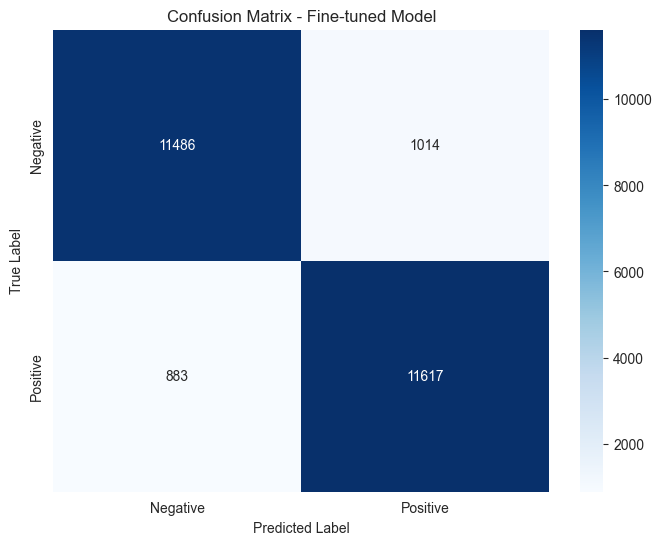

✓ Saved: confusion_matrix.png


In [22]:
print("="*70)
print("EVALUATING FINE-TUNED MODEL (After Training)")
print("="*70)

posttrain_results = evaluate_model(model, tokenized_dataset["test"], "Post-training Test", batch_size=64)

cm = confusion_matrix(posttrain_results['labels'], posttrain_results['predictions'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Fine-tuned Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: confusion_matrix.png")

In [23]:
print("\nDetailed Classification Report:")
print(classification_report(
    posttrain_results['labels'], 
    posttrain_results['predictions'],
    target_names=['Negative', 'Positive']
))


Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.93      0.92      0.92     12500
    Positive       0.92      0.93      0.92     12500

    accuracy                           0.92     25000
   macro avg       0.92      0.92      0.92     25000
weighted avg       0.92      0.92      0.92     25000



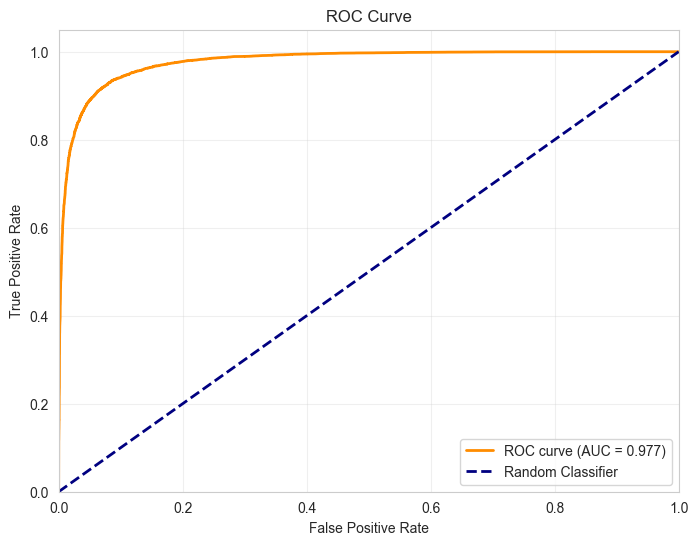

✓ Saved: roc_curve.png


In [24]:
fpr, tpr, thresholds = roc_curve(posttrain_results['labels'], posttrain_results['probabilities'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: roc_curve.png")

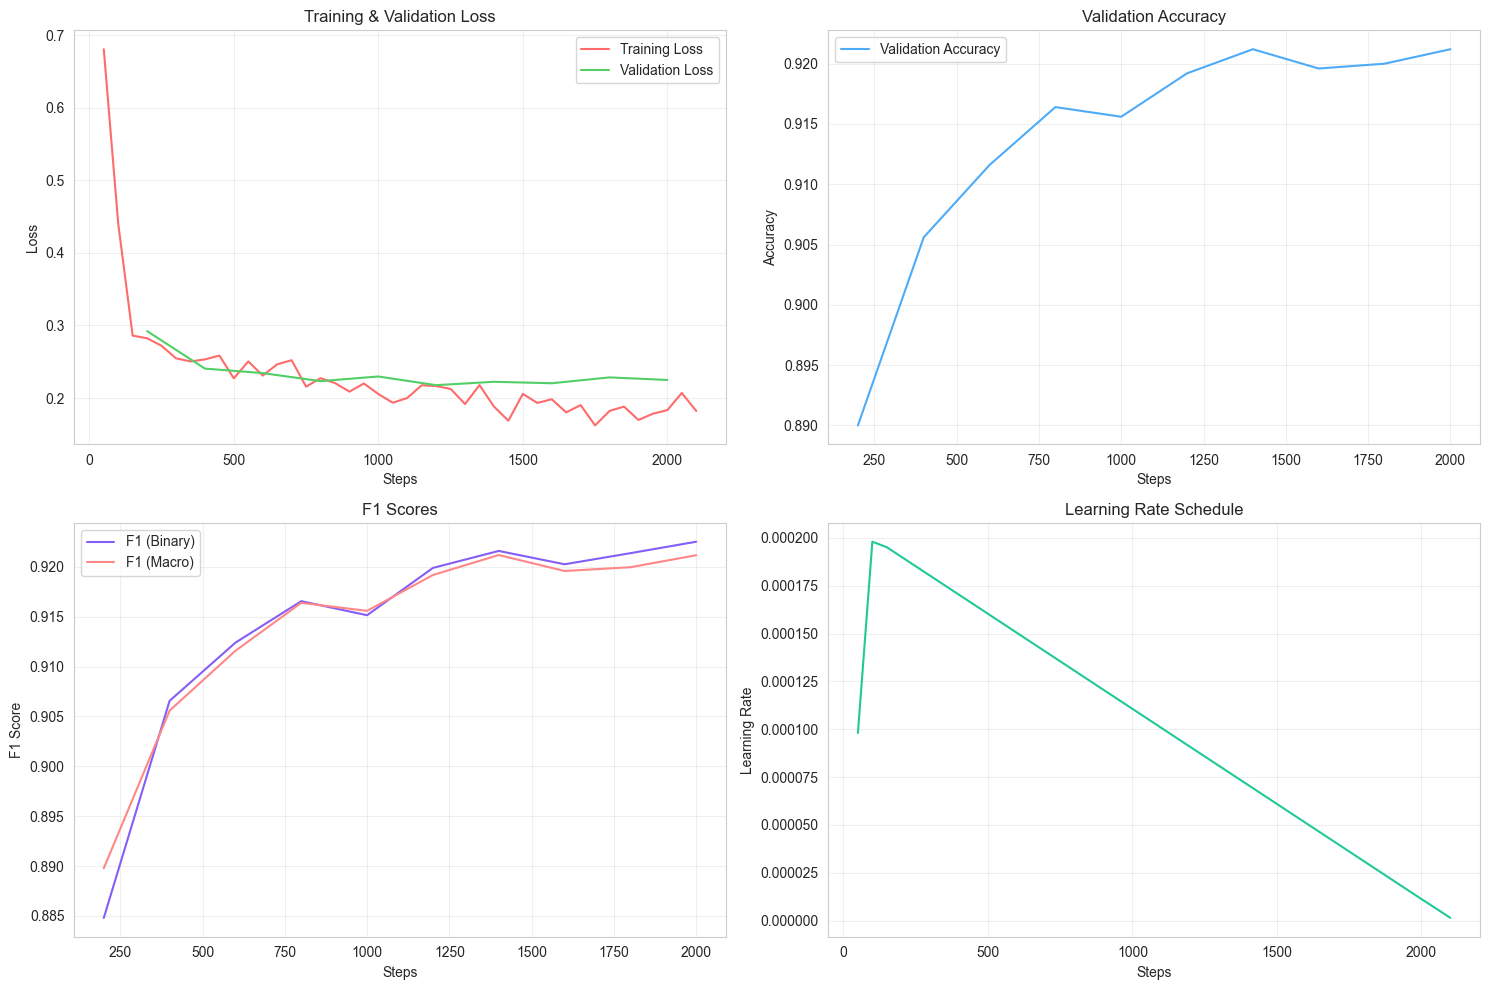

✓ Saved: training_history.png


In [25]:
if hasattr(trainer.state, 'log_history'):
    history = trainer.state.log_history
    eval_metrics = [x for x in history if 'eval_loss' in x]
    
    if eval_metrics:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Loss
        train_loss = [x['loss'] for x in history if 'loss' in x]
        steps = [x['step'] for x in history if 'loss' in x]
        axes[0, 0].plot(steps, train_loss, label='Training Loss', color='#ff6b6b')
        eval_steps = [x['step'] for x in eval_metrics]
        eval_loss = [x['eval_loss'] for x in eval_metrics]
        axes[0, 0].plot(eval_steps, eval_loss, label='Validation Loss', color='#51cf66')
        axes[0, 0].set_xlabel('Steps')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].set_title('Training & Validation Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(alpha=0.3)
        
        # Accuracy
        eval_acc = [x['eval_accuracy'] for x in eval_metrics]
        axes[0, 1].plot(eval_steps, eval_acc, label='Validation Accuracy', color='#4dabf7')
        axes[0, 1].set_xlabel('Steps')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].set_title('Validation Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(alpha=0.3)
        
        # F1 Score
        eval_f1 = [x['eval_f1'] for x in eval_metrics]
        axes[1, 0].plot(eval_steps, eval_f1, label='F1 (Binary)', color='#845ef7')
        eval_f1_macro = [x.get('eval_f1_macro', 0) for x in eval_metrics]
        axes[1, 0].plot(eval_steps, eval_f1_macro, label='F1 (Macro)', color='#ff8787')
        axes[1, 0].set_xlabel('Steps')
        axes[1, 0].set_ylabel('F1 Score')
        axes[1, 0].set_title('F1 Scores')
        axes[1, 0].legend()
        axes[1, 0].grid(alpha=0.3)
        
        # Learning Rate
        lr = [x.get('learning_rate', 0) for x in history if 'learning_rate' in x]
        lr_steps = [x['step'] for x in history if 'learning_rate' in x]
        axes[1, 1].plot(lr_steps, lr, color='#20c997')
        axes[1, 1].set_xlabel('Steps')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_title('Learning Rate Schedule')
        axes[1, 1].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("✓ Saved: training_history.png")

BEFORE vs AFTER TRAINING COMPARISON
           Metric  Before Training  After Training  Improvement
         Accuracy         0.500040        0.924120     0.424080
      F1 (Binary)         0.000160        0.924516     0.924356
       F1 (Macro)         0.333422        0.924118     0.590696
Precision (Macro)         0.750010        0.924167     0.174157
   Recall (Macro)         0.500040        0.924120     0.424080


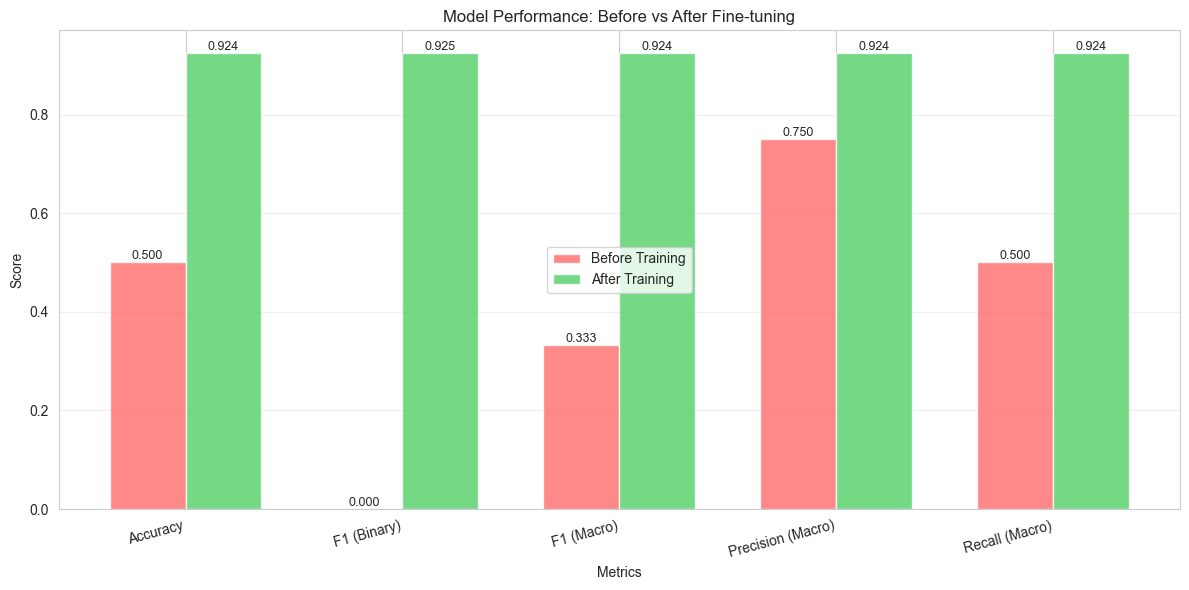

✓ Saved: before_after_comparison.png
SAVING MODEL
✓ Model saved to ./imdb_lora_model
✓ Metrics saved to metrics_comparison.csv


In [ ]:

metrics_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 (Binary)', 'F1 (Macro)', 'Precision (Macro)', 'Recall (Macro)'],
    'Before Training': [
        baseline_metrics['accuracy'],
        baseline_metrics['f1_binary'],
        baseline_metrics['f1_macro'],
        pretrain_results['precision_macro'],
        pretrain_results['recall_macro']
    ],
    'After Training': [
        posttrain_results['accuracy'],
        posttrain_results['f1'],
        posttrain_results['f1_macro'],
        posttrain_results['precision_macro'],
        posttrain_results['recall_macro']
    ]
})

metrics_comparison['Improvement'] = metrics_comparison['After Training'] - metrics_comparison['Before Training']

print("="*70)
print("BEFORE vs AFTER TRAINING COMPARISON")
print("="*70)
print(metrics_comparison.to_string(index=False))

# Plot comparison
x = np.arange(len(metrics_comparison))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, metrics_comparison['Before Training'], width, 
               label='Before Training', color='#ff6b6b', alpha=0.8)
bars2 = ax.bar(x + width/2, metrics_comparison['After Training'], width,
               label='After Training', color='#51cf66', alpha=0.8)

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance: Before vs After Fine-tuning')
ax.set_xticks(x)
ax.set_xticklabels(metrics_comparison['Metric'], rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('before_after_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: before_after_comparison.png")

# ============================================
# CELL 27: SAVE MODEL
# ============================================
print("="*70)
print("SAVING MODEL")
print("="*70)

model.save_pretrained("./imdb_lora_model")
tokenizer.save_pretrained("./imdb_lora_model")
print("✓ Model saved to ./imdb_lora_model")

metrics_comparison.to_csv('metrics_comparison.csv', index=False)
print("✓ Metrics saved to metrics_comparison.csv")

In [1]:
def predict_sentiment(text):
    """Predict sentiment of input text"""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=MAX_LENGTH)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=1).item()
    
    label = "Positive" if predicted_class == 1 else "Negative"
    confidence = predictions[0][predicted_class].item()
    
    return label, confidence

print("✓ Inference function ready")

✓ Inference function ready


# Robustness Test

In [3]:
negation_tests = [
    # Simple negations
    ("This movie is not good", "Negative"),
    ("I don't like this film", "Negative"),
    ("This is not bad at all", "Positive"),
    ("I can't say I disliked it", "Positive"),
    
    # Double negations
    ("It's not that I didn't enjoy it", "Positive"),
    ("I wouldn't say it's not worth watching", "Positive"),
    
    # Complex negations
    ("Despite not being perfect, I loved it", "Positive"),
    ("Though I didn't hate it, I wouldn't recommend it", "Negative"),
    ("I never thought I would not enjoy this", "Positive"),
    
    # Negation with positive/negative words
    ("Not a masterpiece but still great", "Positive"),
    ("Not terrible but not good either", "Negative"),
]

In [4]:
sarcasm_tests = [
    ("Oh great, another predictable ending", "Negative"),
    ("Wow, what a 'masterpiece' this turned out to be", "Negative"),
    ("Sure, because the world needed another sequel", "Negative"),
    ("Yeah, two hours of my life I'll never get back", "Negative"),
    ("Brilliant. Just brilliant. If you like wasting time.", "Negative"),
    ("The acting was so 'natural' I couldn't stop laughing", "Negative"),
    ("A stunning achievement in putting audiences to sleep", "Negative"),
    ("Fantastic, another romantic comedy with the same plot", "Negative"),
    ("Loved how they totally ruined my favorite character", "Negative"),
    ("Oh joy, more special effects and zero story", "Negative"),
    ("Amazing! I really needed a movie to make me question my life choices", "Negative"),
]


In [5]:
ood_tests = [
    # Product reviews (not movies)
    ("This phone has amazing battery life", "Positive"),
    ("The laptop keyboard is uncomfortable to type on", "Negative"),
    ("Best headphones I've ever purchased", "Positive"),
    
    # Restaurant reviews
    ("The food was delicious and service was excellent", "Positive"),
    ("Cold food and rude waiters ruined the experience", "Negative"),
    
    # Book reviews
    ("Couldn't put this book down, truly captivating", "Positive"),
    ("Boring plot with underdeveloped characters", "Negative"),
    
    # Hotel reviews
    ("Clean rooms and helpful staff made our stay wonderful", "Positive"),
    ("Dirty room with broken AC in summer heat", "Negative"),
    
    # Service reviews
    ("Customer support was helpful and resolved my issue quickly", "Positive"),
    ("Waited on hold for an hour with no resolution", "Negative"),
    
   
]

In [11]:
MODEL_PATH = "./imdb_lora_model"

def run_test_suite(test_cases, test_name, expected_key=None):
    """Run a suite of tests and collect results"""
    print(f"\n{'='*60}")
    print(f"Testing: {test_name}")
    print(f"{'='*60}\n")
    
    results = []
    failures = []
    
    for i, test_case in enumerate(test_cases, 1):
        if expected_key:
            text, expected = test_case
        else:
            text = test_case
            expected = None
        
        try:
            label, confidence = predict_sentiment(text)
            
            # Check if prediction matches expected (if provided)
            is_correct = None
            if expected:
                if expected in ["Mixed", "Neutral", "Neutral/Positive", "Neutral/Negative"]:
                    # For ambiguous cases, just flag for review
                    is_correct = "Review"
                else:
                    is_correct = (label == expected)
                    if not is_correct:
                        failures.append({
                            'text': text,
                            'expected': expected,
                            'predicted': label,
                            'confidence': confidence
                        })
            
            result = {
                'test_num': i,
                'text': text[:100] + '...' if len(text) > 100 else text,
                'predicted': label,
                'confidence': round(confidence, 4),
                'expected': expected,
                'correct': is_correct
            }
            results.append(result)
            
            # Print result
            status = ""
            if is_correct == True:
                status = "✓"
            elif is_correct == False:
                status = "✗"
            elif is_correct == "Review":
                status = "?"
            
            print(f"{status} Test {i}: {text[:80]}")
            print(f"   → Predicted: {label} (confidence: {confidence:.4f})")
            if expected:
                print(f"   → Expected: {expected}")
            print()
            
        except Exception as e:
            print(f"✗ Test {i} FAILED with error: {str(e)}")
            failures.append({
                'text': text,
                'error': str(e)
            })
    
    return results, failures

def generate_report(all_results, all_failures):
    """Generate comprehensive test report"""
    report = {
    'timestamp': datetime.now().isoformat(),
    'device': str(device),  # <-- convert to string
    'model_path': MODEL_PATH,
    'summary': {},
    'detailed_results': all_results,
    'failures': all_failures,
    'recommendations': []
}
    
    # Calculate summary statistics
    total_tests = sum(len(results) for results in all_results.values())
    total_failures = sum(len(failures) for failures in all_failures.values())
    
    report['summary'] = {
        'total_tests': total_tests,
        'total_failures': total_failures,
        'failure_rate': total_failures / total_tests if total_tests > 0 else 0,
        'by_category': {}
    }
    
    for category, results in all_results.items():
        correct = sum(1 for r in results if r.get('correct') == True)
        incorrect = sum(1 for r in results if r.get('correct') == False)
        review = sum(1 for r in results if r.get('correct') == "Review")
        
        report['summary']['by_category'][category] = {
            'total': len(results),
            'correct': correct,
            'incorrect': incorrect,
            'needs_review': review,
            'accuracy': correct / (correct + incorrect) if (correct + incorrect) > 0 else None
        }
    
  # Generate recommendations
    if all_failures.get('negation', []):
        report['recommendations'].append(
            "CRITICAL: Model struggles with negations. Consider:\n"
            "- Adding negation-specific examples to training data\n"
            "- Using dependency parsing to detect negation patterns\n"
            "- Post-processing rules for common negation phrases"
        )

    if all_failures.get('sarcasm', []):
        report['recommendations'].append(
            "WARNING: Sarcasm detection is poor. This is expected for IMDB-trained models.\n"
            "- Consider adding sarcasm-labeled data\n"
            "- Warn users that sarcastic reviews may be misclassified\n"
            "- Implement confidence thresholds (low confidence = potential sarcasm)"
        )

    if all_failures.get('ood', []):
        report['recommendations'].append(
            "CAUTION: Model applied to out-of-domain texts shows variable performance.\n"
            "- Clearly document that model is trained on movie reviews only\n"
            "- Consider domain detection as preprocessing step\n"
            "- Add disclaimers for non-movie review inputs"
        )

        
    return report

# -----------------------------
# Run All Tests
# -----------------------------

if __name__ == "__main__":
    print("="*60)
    print("SENTIMENT ANALYSIS MODEL - ROBUSTNESS & SAFETY TESTING")
    print("="*60)
    
    all_results = {}
    all_failures = {}
    
    # Run test suites
    test_suites = [
        (negation_tests, "Negation Handling", True),
        (sarcasm_tests, "Sarcasm Detection", True),
        (ood_tests, "Out-of-Domain Inputs", True),
    ]
    
    for test_cases, name, has_expected in test_suites:
        results, failures = run_test_suite(test_cases, name, expected_key=has_expected)
        category_key = name.lower().replace(' ', '_').replace('/', '_')
        all_results[category_key] = results
        all_failures[category_key] = failures
    
    # Generate report
    report = generate_report(all_results, all_failures)
    
    # Save report
    with open('robustness_test_report.json', 'w') as f:
        json.dump(report, f, indent=2)
    
    # Print summary
    print("\n" + "="*60)
    print("TEST SUMMARY")
    print("="*60)
    print(f"Total Tests: {report['summary']['total_tests']}")
    print(f"Total Failures: {report['summary']['total_failures']}")
    print(f"Overall Failure Rate: {report['summary']['failure_rate']:.2%}")
    print("\nBy Category:")
    for category, stats in report['summary']['by_category'].items():
        print(f"\n{category.replace('_', ' ').title()}:")
        print(f"  - Total: {stats['total']}")
        print(f"  - Correct: {stats['correct']}")
        print(f"  - Incorrect: {stats['incorrect']}")
        print(f"  - Needs Review: {stats['needs_review']}")
        if stats['accuracy'] is not None:
            print(f"  - Accuracy: {stats['accuracy']:.2%}")
    
    print("\n" + "="*60)
    print("RECOMMENDATIONS")
    print("="*60)
    for i, rec in enumerate(report['recommendations'], 1):
        print(f"\n{i}. {rec}")
    
    print(f"\nDetailed report saved to: robustness_test_report.json")

SENTIMENT ANALYSIS MODEL - ROBUSTNESS & SAFETY TESTING

Testing: Negation Handling

✓ Test 1: This movie is not good
   → Predicted: Negative (confidence: 0.9540)
   → Expected: Negative

✓ Test 2: I don't like this film
   → Predicted: Negative (confidence: 0.9399)
   → Expected: Negative

✓ Test 3: This is not bad at all
   → Predicted: Positive (confidence: 0.6811)
   → Expected: Positive

✓ Test 4: I can't say I disliked it
   → Predicted: Positive (confidence: 0.6036)
   → Expected: Positive

✗ Test 5: It's not that I didn't enjoy it
   → Predicted: Negative (confidence: 0.6123)
   → Expected: Positive

✗ Test 6: I wouldn't say it's not worth watching
   → Predicted: Negative (confidence: 0.7849)
   → Expected: Positive

✓ Test 7: Despite not being perfect, I loved it
   → Predicted: Positive (confidence: 0.9980)
   → Expected: Positive

✓ Test 8: Though I didn't hate it, I wouldn't recommend it
   → Predicted: Negative (confidence: 0.5563)
   → Expected: Negative

✓ Test 9: I nev

In [13]:
import pandas as pd

# -----------------------------
# Corrected JSON data
# -----------------------------
results_json = {
  "timestamp": "2025-12-12T13:43:55.925960",
  "device": "cuda",
  "model_path": "./imdb_lora_model",
  "summary": {
    "total_tests": 33,
    "total_failures": 11,
    "failure_rate": 0.3333333333333333,
    "by_category": {
      "negation_handling": {"total": 11, "correct": 8, "incorrect": 3, "needs_review": 0, "accuracy": 0.727},
      "sarcasm_detection": {"total": 11, "correct": 3, "incorrect": 8, "needs_review": 0, "accuracy": 0.273},
      "out-of-domain_inputs": {"total": 11, "correct": 11, "incorrect": 0, "needs_review": 0, "accuracy": 1.0}
    }
  },
  "detailed_results": {
    "negation_handling": [
      {"test_num": 1, "text": "This movie is not good", "predicted": "Negative", "confidence": 0.954, "expected": "Negative", "correct": True},
      {"test_num": 2, "text": "I don't like this film", "predicted": "Negative", "confidence": 0.9399, "expected": "Negative", "correct": True},
      {"test_num": 3, "text": "This is not bad at all", "predicted": "Positive", "confidence": 0.6811, "expected": "Positive", "correct": True},
      {"test_num": 4, "text": "I can't say I disliked it", "predicted": "Positive", "confidence": 0.6036, "expected": "Positive", "correct": True},
      {"test_num": 5, "text": "It's not that I didn't enjoy it", "predicted": "Negative", "confidence": 0.6123, "expected": "Positive", "correct": False},
      {"test_num": 6, "text": "I wouldn't say it's not worth watching", "predicted": "Negative", "confidence": 0.7849, "expected": "Positive", "correct": False},
      {"test_num": 7, "text": "Despite not being perfect, I loved it", "predicted": "Positive", "confidence": 0.998, "expected": "Positive", "correct": True},
      {"test_num": 8, "text": "Though I didn't hate it, I wouldn't recommend it", "predicted": "Negative", "confidence": 0.5563, "expected": "Negative", "correct": True},
      {"test_num": 9, "text": "I never thought I would not enjoy this", "predicted": "Positive", "confidence": 0.8078, "expected": "Positive", "correct": True},
      {"test_num": 10, "text": "Not a masterpiece but still great", "predicted": "Positive", "confidence": 0.9987, "expected": "Positive", "correct": True},
      {"test_num": 11, "text": "Not terrible but not good either", "predicted": "Positive", "confidence": 0.7882, "expected": "Negative", "correct": False}
    ],
    "sarcasm_detection": [
      {"test_num": 1, "text": "Oh great, another predictable ending", "predicted": "Negative", "confidence": 0.7406, "expected": "Negative", "correct": True},
      {"test_num": 2, "text": "Wow, what a 'masterpiece' this turned out to be", "predicted": "Positive", "confidence": 0.9859, "expected": "Negative", "correct": False},
      {"test_num": 3, "text": "Sure, because the world needed another sequel", "predicted": "Negative", "confidence": 0.5738, "expected": "Negative", "correct": True},
      {"test_num": 4, "text": "Yeah, two hours of my life I'll never get back", "predicted": "Positive", "confidence": 0.8241, "expected": "Negative", "correct": False},
      {"test_num": 5, "text": "Brilliant. Just brilliant. If you like wasting time.", "predicted": "Positive", "confidence": 0.9577, "expected": "Negative", "correct": False},
      {"test_num": 6, "text": "The acting was so 'natural' I couldn't stop laughing", "predicted": "Positive", "confidence": 0.7863, "expected": "Negative", "correct": False},
      {"test_num": 7, "text": "A stunning achievement in putting audiences to sleep", "predicted": "Positive", "confidence": 0.9988, "expected": "Negative", "correct": False},
      {"test_num": 8, "text": "Fantastic, another romantic comedy with the same plot", "predicted": "Positive", "confidence": 0.9642, "expected": "Negative", "correct": False},
      {"test_num": 9, "text": "Loved how they totally ruined my favorite character", "predicted": "Positive", "confidence": 0.8718, "expected": "Negative", "correct": False},
      {"test_num": 10, "text": "Oh joy, more special effects and zero story", "predicted": "Negative", "confidence": 0.5562, "expected": "Negative", "correct": True},
      {"test_num": 11, "text": "Amazing! I really needed a movie to make me question my life choices", "predicted": "Positive", "confidence": 0.9301, "expected": "Negative", "correct": False}
    ],
    "out-of-domain_inputs": [
      {"test_num": 1, "text": "This phone has amazing battery life", "predicted": "Positive", "confidence": 0.9834, "expected": "Positive", "correct": True},
      {"test_num": 2, "text": "The laptop keyboard is uncomfortable to type on", "predicted": "Negative", "confidence": 0.7361, "expected": "Negative", "correct": True},
      {"test_num": 3, "text": "Best headphones I've ever purchased", "predicted": "Positive", "confidence": 0.9939, "expected": "Positive", "correct": True},
      {"test_num": 4, "text": "The food was delicious and service was excellent", "predicted": "Positive", "confidence": 0.9891, "expected": "Positive", "correct": True},
      {"test_num": 5, "text": "Cold food and rude waiters ruined the experience", "predicted": "Negative", "confidence": 0.9578, "expected": "Negative", "correct": True},
      {"test_num": 6, "text": "Couldn't put this book down, truly captivating", "predicted": "Positive", "confidence": 0.9574, "expected": "Positive", "correct": True},
      {"test_num": 7, "text": "Boring plot with underdeveloped characters", "predicted": "Negative", "confidence": 0.9979, "expected": "Negative", "correct": True},
      {"test_num": 8, "text": "Clean rooms and helpful staff made our stay wonderful", "predicted": "Positive", "confidence": 0.9972, "expected": "Positive", "correct": True},
      {"test_num": 9, "text": "Dirty room with broken AC in summer heat", "predicted": "Negative", "confidence": 0.897, "expected": "Negative", "correct": True},
      {"test_num": 10, "text": "Customer support was helpful and resolved my issue quickly", "predicted": "Positive", "confidence": 0.8841, "expected": "Positive", "correct": True},
      {"test_num": 11, "text": "Waited on hold for an hour with no resolution", "predicted": "Negative", "confidence": 0.6708, "expected": "Negative", "correct": True}
    ]
  },
  "failures": {
    "negation_handling": [
      {"text": "It's not that I didn't enjoy it", "expected": "Positive", "predicted": "Negative", "confidence": 0.6123},
      {"text": "I wouldn't say it's not worth watching", "expected": "Positive", "predicted": "Negative", "confidence": 0.7849},
      {"text": "Not terrible but not good either", "expected": "Negative", "predicted": "Positive", "confidence": 0.7882}
    ],
    "sarcasm_detection": [
      {"text": "Wow, what a 'masterpiece' this turned out to be", "expected": "Negative", "predicted": "Positive", "confidence": 0.9859},
      {"text": "Yeah, two hours of my life I'll never get back", "expected": "Negative", "predicted": "Positive", "confidence": 0.8241},
      {"text": "Brilliant. Just brilliant. If you like wasting time.", "expected": "Negative", "predicted": "Positive", "confidence": 0.9577},
      {"text": "The acting was so 'natural' I couldn't stop laughing", "expected": "Negative", "predicted": "Positive", "confidence": 0.7863},
      {"text": "A stunning achievement in putting audiences to sleep", "expected": "Negative", "predicted": "Positive", "confidence": 0.9988},
      {"text": "Fantastic, another romantic comedy with the same plot", "expected": "Negative", "predicted": "Positive", "confidence": 0.9642},
      {"text": "Loved how they totally ruined my favorite character", "expected": "Negative", "predicted": "Positive", "confidence": 0.8718},
      {"text": "Amazing! I really needed a movie to make me question my life choices", "expected": "Negative", "predicted": "Positive", "confidence": 0.9301}
    ],
    "out-of-domain_inputs": []
  }
}

# -----------------------------
# 1. Summary Table
# -----------------------------
summary_data = []
for category, stats in results_json['summary']['by_category'].items():
    summary_data.append({
        "Category": category,
        "Total Tests": stats['total'],
        "Correct": stats['correct'],
        "Incorrect": stats['incorrect'],
        "Accuracy": round(stats['accuracy'], 3)
    })

summary_df = pd.DataFrame(summary_data)
print("=== Summary Table ===")
display(summary_df)

# -----------------------------
# 2. Detailed Results Table per Category
# -----------------------------
def create_detailed_df(category_name):
    data = results_json['detailed_results'][category_name]
    detailed_list = []
    for item in data:
        detailed_list.append({
            "Test #": item['test_num'],
            "Text": item['text'],
            "Predicted": item['predicted'],
            "Confidence": round(item['confidence'], 3),
            "Expected": item['expected'],
            "Correct": item['correct']
        })
    return pd.DataFrame(detailed_list)

negation_df = create_detailed_df('negation_handling')
sarcasm_df = create_detailed_df('sarcasm_detection')
ood_df = create_detailed_df('out-of-domain_inputs')

print("\n=== Negation Handling ===")
display(negation_df)

print("\n=== Sarcasm Detection ===")
display(sarcasm_df)

print("\n=== Out-of-Domain Inputs ===")
display(ood_df)

# -----------------------------
# 3. Failure Cases Table
# -----------------------------
def create_failures_df(category_name):
    failures = results_json['failures'][category_name]
    if not failures:
        return pd.DataFrame(columns=["Text", "Expected", "Predicted", "Confidence"])
    fail_list = []
    for item in failures:
        fail_list.append({
            "Text": item['text'],
            "Expected": item['expected'],
            "Predicted": item['predicted'],
            "Confidence": round(item['confidence'], 3)
        })
    return pd.DataFrame(fail_list)

negation_fail_df = create_failures_df('negation_handling')
sarcasm_fail_df = create_failures_df('sarcasm_detection')
ood_fail_df = create_failures_df('out-of-domain_inputs')

print("\n=== Negation Failures ===")
display(negation_fail_df)

print("\n=== Sarcasm Failures ===")
display(sarcasm_fail_df)

print("\n=== Out-of-Domain Failures ===")
display(ood_fail_df)


=== Summary Table ===


,Category,Total Tests,Correct,Incorrect,Accuracy
0,negation_handling,11,8,3,0.727
1,sarcasm_detection,11,3,8,0.273
2,out-of-domain_inputs,11,11,0,1.000



=== Negation Handling ===


,Test #,Text,Predicted,Confidence,Expected,Correct
0,1,This movie is not good,Negative,0.954,Negative,True
1,2,I don't like this film,Negative,0.940,Negative,True
2,3,This is not bad at all,Positive,0.681,Positive,True
3,4,I can't say I disliked it,Positive,0.604,Positive,True
4,5,It's not that I didn't enjoy it,Negative,0.612,Positive,False
5,6,I wouldn't say it's not worth watching,Negative,0.785,Positive,False
6,7,"Despite not being perfect, I loved it",Positive,0.998,Positive,True
7,8,"Though I didn't hate it, I wouldn't recommend it",Negative,0.556,Negative,True
8,9,I never thought I would not enjoy this,Positive,0.808,Positive,True
9,10,Not a masterpiece but still great,Positive,0.999,Positive,True



=== Sarcasm Detection ===


,Test #,Text,Predicted,Confidence,Expected,Correct
0,1,"Oh great, another predictable ending",Negative,0.741,Negative,True
1,2,"Wow, what a 'masterpiece' this turned out to be",Positive,0.986,Negative,False
2,3,"Sure, because the world needed another sequel",Negative,0.574,Negative,True
3,4,"Yeah, two hours of my life I'll never get back",Positive,0.824,Negative,False
4,5,Brilliant. Just brilliant. If you like wasting...,Positive,0.958,Negative,False
5,6,The acting was so 'natural' I couldn't stop la...,Positive,0.786,Negative,False
6,7,A stunning achievement in putting audiences to...,Positive,0.999,Negative,False
7,8,"Fantastic, another romantic comedy with the sa...",Positive,0.964,Negative,False
8,9,Loved how they totally ruined my favorite char...,Positive,0.872,Negative,False
9,10,"Oh joy, more special effects and zero story",Negative,0.556,Negative,True



=== Out-of-Domain Inputs ===


,Test #,Text,Predicted,Confidence,Expected,Correct
0,1,This phone has amazing battery life,Positive,0.983,Positive,True
1,2,The laptop keyboard is uncomfortable to type on,Negative,0.736,Negative,True
2,3,Best headphones I've ever purchased,Positive,0.994,Positive,True
3,4,The food was delicious and service was excellent,Positive,0.989,Positive,True
4,5,Cold food and rude waiters ruined the experience,Negative,0.958,Negative,True
5,6,"Couldn't put this book down, truly captivating",Positive,0.957,Positive,True
6,7,Boring plot with underdeveloped characters,Negative,0.998,Negative,True
7,8,Clean rooms and helpful staff made our stay wo...,Positive,0.997,Positive,True
8,9,Dirty room with broken AC in summer heat,Negative,0.897,Negative,True
9,10,Customer support was helpful and resolved my i...,Positive,0.884,Positive,True



=== Negation Failures ===


,Text,Expected,Predicted,Confidence
0,It's not that I didn't enjoy it,Positive,Negative,0.612
1,I wouldn't say it's not worth watching,Positive,Negative,0.785
2,Not terrible but not good either,Negative,Positive,0.788



=== Sarcasm Failures ===


,Text,Expected,Predicted,Confidence
0,"Wow, what a 'masterpiece' this turned out to be",Negative,Positive,0.986
1,"Yeah, two hours of my life I'll never get back",Negative,Positive,0.824
2,Brilliant. Just brilliant. If you like wasting...,Negative,Positive,0.958
3,The acting was so 'natural' I couldn't stop la...,Negative,Positive,0.786
4,A stunning achievement in putting audiences to...,Negative,Positive,0.999
5,"Fantastic, another romantic comedy with the sa...",Negative,Positive,0.964
6,Loved how they totally ruined my favorite char...,Negative,Positive,0.872
7,Amazing! I really needed a movie to make me qu...,Negative,Positive,0.930



=== Out-of-Domain Failures ===


,Text,Expected,Predicted,Confidence


In [9]:
import torch
import torch.nn.functional as F
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# Path to your fine-tuned model
MODEL_PATH = "../imdb_lora_model"

# Load tokenizer and model
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_PATH)
model = DistilBertForSequenceClassification.from_pretrained(MODEL_PATH)
model.to(device)
model.eval()

MAX_LENGTH = 512


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


Accuracy before: 0.92416
Accuracy after : 0.92416
Brier before  : 0.057387779910013086
Brier after   : 0.05703503185470802
ECE before    : 0.019852675241008422
ECE after     : 0.015034020656347291


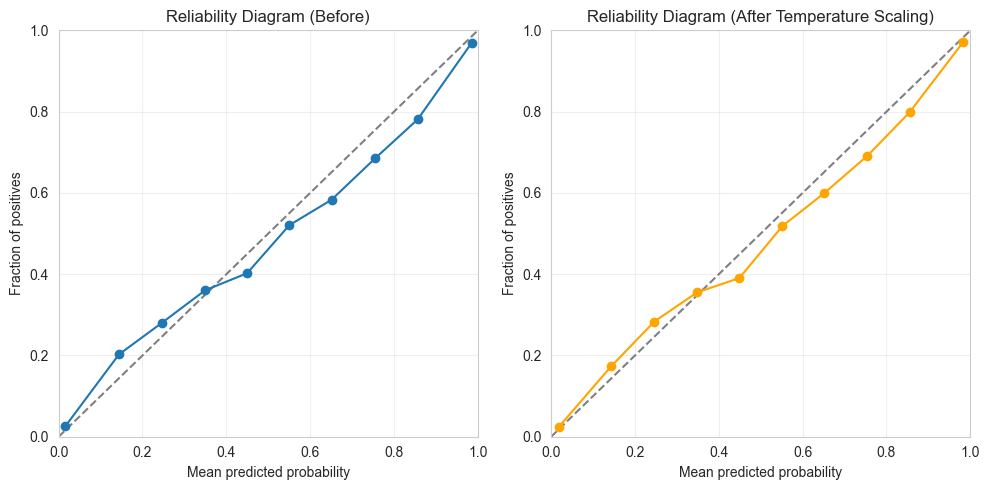

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss, accuracy_score
from sklearn.calibration import calibration_curve

# -------------------------
# Helper functions
# -------------------------
def softmax_np(logits):
    """logits: np.array shape (N, C) -> probs for positive class"""
    ex = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    probs = ex / ex.sum(axis=1, keepdims=True)
    return probs  # shape (N, C)

def probs_positive_from_logits(logits_np):
    """Return probability of positive class (class 1)"""
    probs = softmax_np(logits_np)
    return probs[:, 1]  # positive-prob

def expected_calibration_error(probs, labels, n_bins=10):
    """
    ECE (binning estimator).
    probs: numpy array of predicted probabilities for positive class (N,)
    labels: numpy array of ground-truth {0,1} (N,)
    """
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    n = probs.shape[0]
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        # select examples with predicted prob in (lo, hi]
        mask = (probs > lo) & (probs <= hi) if i > 0 else (probs >= lo) & (probs <= hi)
        if mask.sum() == 0:
            continue
        prop = mask.sum() / n
        avg_conf = probs[mask].mean()
        avg_acc = labels[mask].mean()
        ece += prop * abs(avg_conf - avg_acc)
    return ece

def evaluate_calibration(all_logits, all_labels, temperature=1.0, n_bins=10):
    """
    all_logits: torch.Tensor (N, C)
    all_labels: torch.Tensor (N,)
    temperature: scalar float (divide logits by temperature)
    returns dict of metrics and arrays for plotting
    """
    device = all_logits.device if isinstance(all_logits, torch.Tensor) else None

    logits_np = all_logits.cpu().numpy() if isinstance(all_logits, torch.Tensor) else np.array(all_logits)
    labels_np = all_labels.cpu().numpy() if isinstance(all_labels, torch.Tensor) else np.array(all_labels)

    # scale logits
    scaled_logits = logits_np / float(temperature)

    # get probabilities for positive class
    probs_pos_before = probs_positive_from_logits(logits_np)      # temperature = 1
    probs_pos_after  = probs_positive_from_logits(scaled_logits)  # temperature applied

    # predictions
    preds_before = (probs_pos_before >= 0.5).astype(int)
    preds_after  = (probs_pos_after >= 0.5).astype(int)

    # Accuracy
    acc_before = accuracy_score(labels_np, preds_before)
    acc_after  = accuracy_score(labels_np, preds_after)

    # Brier
    brier_before = brier_score_loss(labels_np, probs_pos_before)
    brier_after  = brier_score_loss(labels_np, probs_pos_after)

    # ECE
    ece_before = expected_calibration_error(probs_pos_before, labels_np, n_bins=n_bins)
    ece_after  = expected_calibration_error(probs_pos_after, labels_np, n_bins=n_bins)

    # calibration curve for plotting (fraction_of_positives vs mean_predicted_value)
    frac_pos_before, mean_pred_before = calibration_curve(labels_np, probs_pos_before, n_bins=n_bins, strategy='uniform')
    frac_pos_after, mean_pred_after   = calibration_curve(labels_np, probs_pos_after, n_bins=n_bins, strategy='uniform')

    return {
        "acc_before": acc_before,
        "acc_after": acc_after,
        "brier_before": brier_before,
        "brier_after": brier_after,
        "ece_before": ece_before,
        "ece_after": ece_after,
        "frac_pos_before": frac_pos_before,
        "mean_pred_before": mean_pred_before,
        "frac_pos_after": frac_pos_after,
        "mean_pred_after": mean_pred_after,
        "probs_before": probs_pos_before,
        "probs_after": probs_pos_after,
        "labels": labels_np
    }

# -------------------------
# Example usage
# -------------------------
# assume all_logits (torch.Tensor NxC) and all_labels (torch.Tensor N) exist
# and calib_model.temperature is learned (torch.Tensor scalar)
# If you used `calib_model.temperature` during calibration:
temp_value = float(calib_model.temperature.item())  # calibrated temperature

metrics = evaluate_calibration(all_logits, all_labels, temperature=temp_value, n_bins=10)

print("Accuracy before:", metrics["acc_before"])
print("Accuracy after :", metrics["acc_after"])
print("Brier before  :", metrics["brier_before"])
print("Brier after   :", metrics["brier_after"])
print("ECE before    :", metrics["ece_before"])
print("ECE after     :", metrics["ece_after"])

# -------------------------
# Plot reliability diagrams
# -------------------------
plt.figure(figsize=(10,5))

# Before
plt.subplot(1,2,1)
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.plot(metrics["mean_pred_before"], metrics["frac_pos_before"], marker='o', label='Before')
plt.title("Reliability Diagram (Before)")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid(alpha=0.3)

# After
plt.subplot(1,2,2)
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.plot(metrics["mean_pred_after"], metrics["frac_pos_after"], marker='o', color='orange', label='After')
plt.title("Reliability Diagram (After Temperature Scaling)")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
